<a href="https://www.kaggle.com/code/dishaasinghi/resnet-simplified?scriptVersionId=177249171" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from sklearn.decomposition import PCA
from tensorflow.keras import layers

import warnings , os
warnings.filterwarnings(action='ignore')

import umap
import umap.plot

2024-05-12 16:19:57.681945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 16:19:57.682058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 16:19:57.821694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = "/kaggle/input/fer2013/train"
test = "/kaggle/input/fer2013/test"

In [3]:
angry = os.listdir(train + "/angry")
disgust = os.listdir(train + "/disgust")
fear = os.listdir(train + "/fear")
happy = os.listdir(train + "/happy")
neutral = os.listdir(train + "/neutral")
sad = os.listdir(train + "/sad")
surprise = os.listdir(train + "/surprise")

In [4]:
number_train = len(angry)+len(disgust)+len(fear)+len(happy)+len(neutral)+len(sad)+len(surprise)
number_train

28709

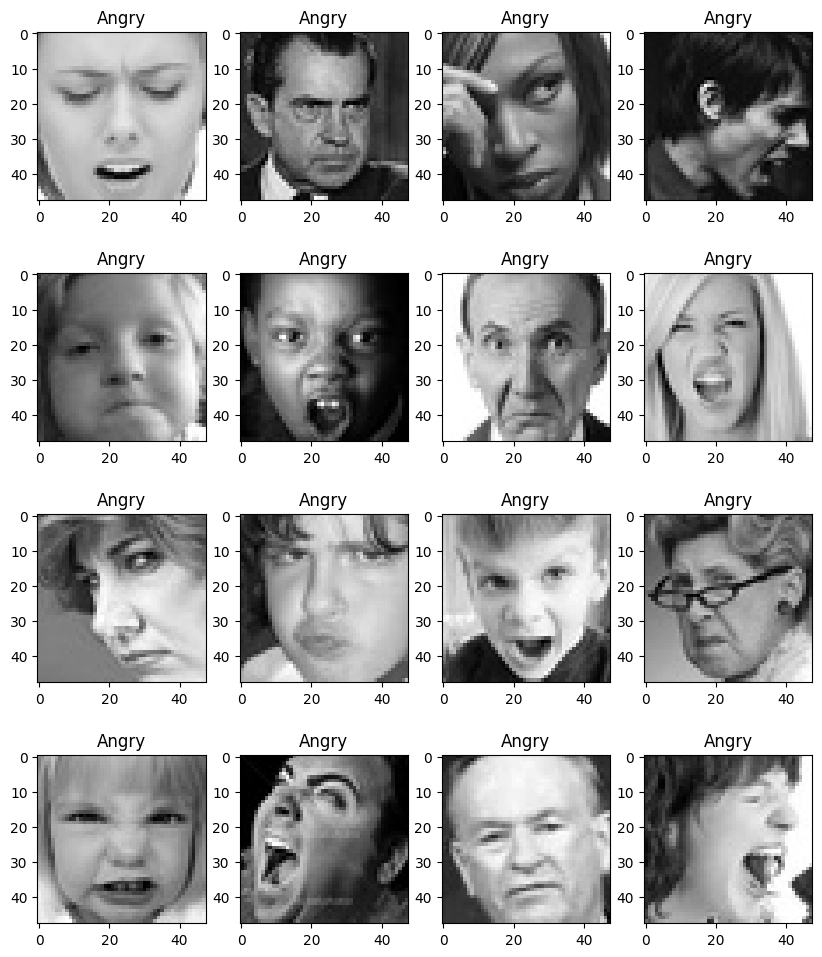

In [5]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/angry", angry[i])), cmap = 'gray')
    plt.title('Angry')
plt.show()

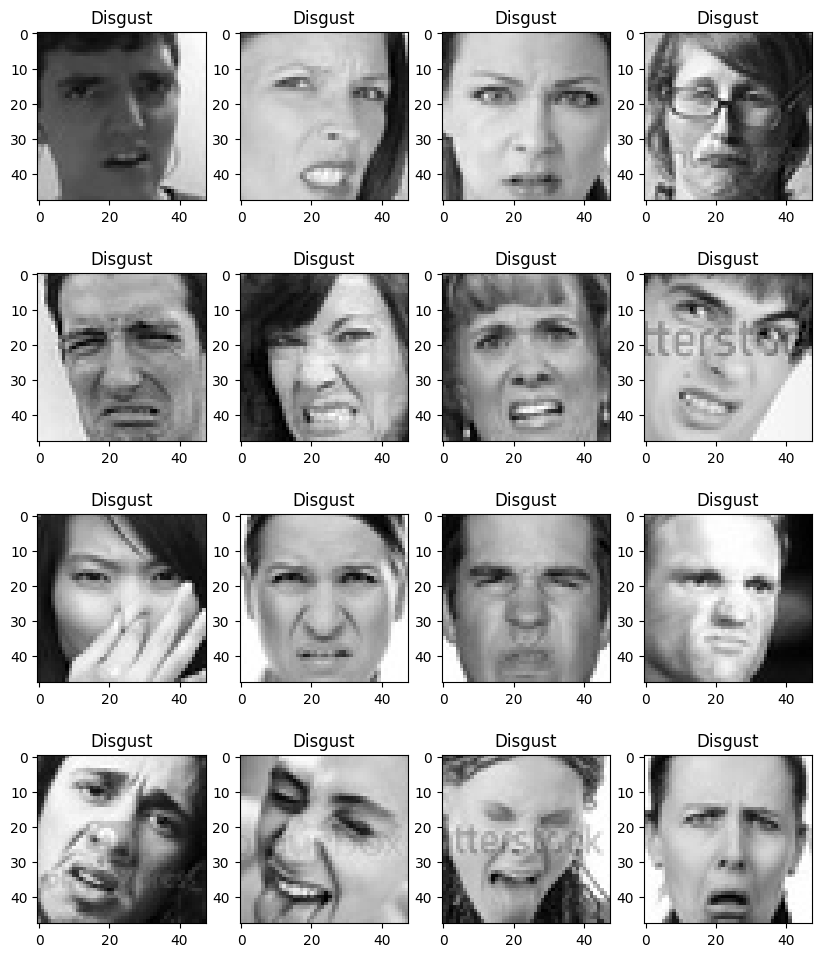

In [6]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/disgust", disgust[i])), cmap = 'gray')
    plt.title('Disgust')
plt.show()

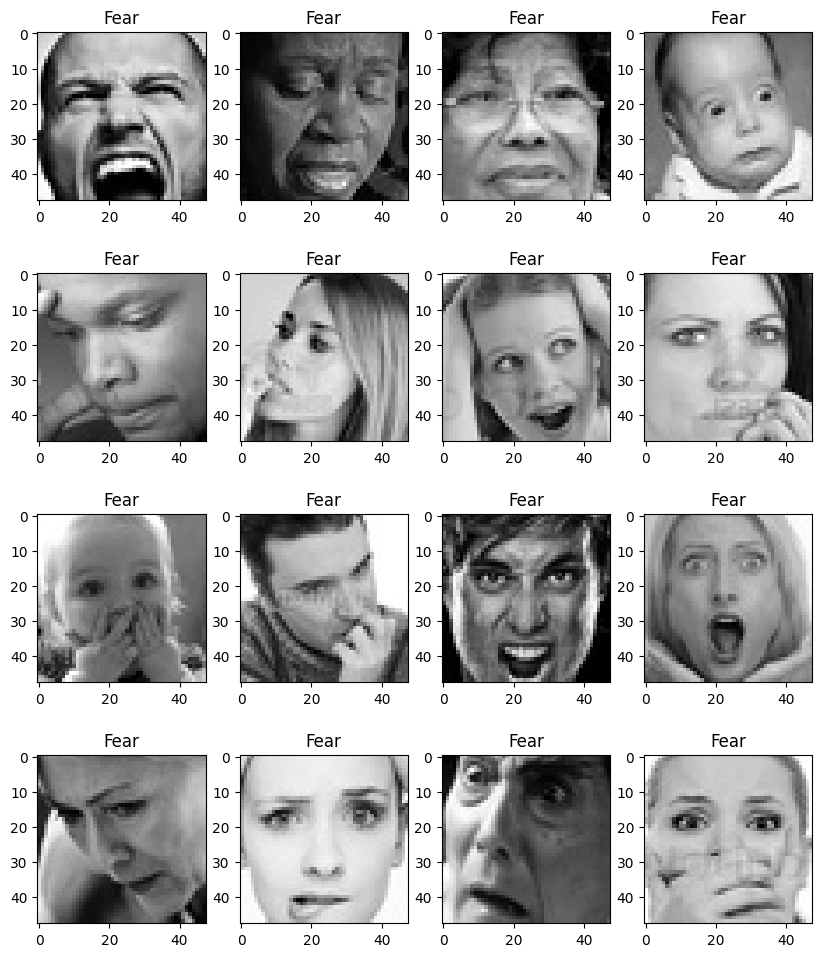

In [7]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/fear", fear[i])), cmap = 'gray')
    plt.title('Fear')
plt.show()

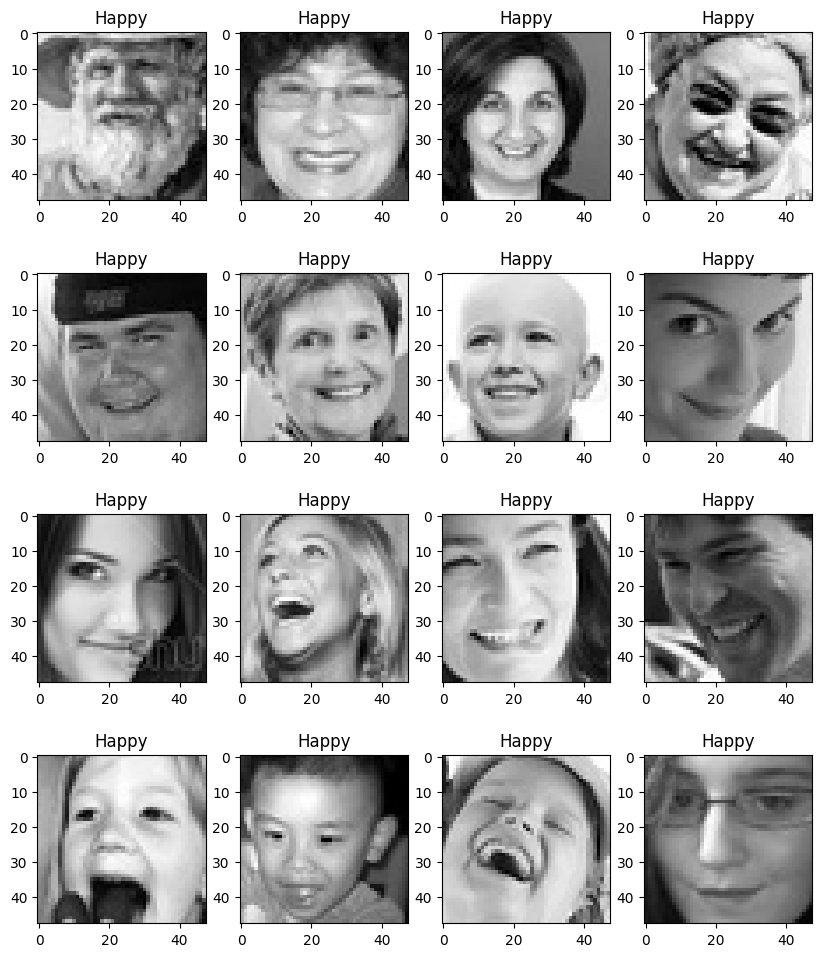

In [8]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/happy", happy[i])), cmap = 'gray')
    plt.title('Happy')
plt.show()

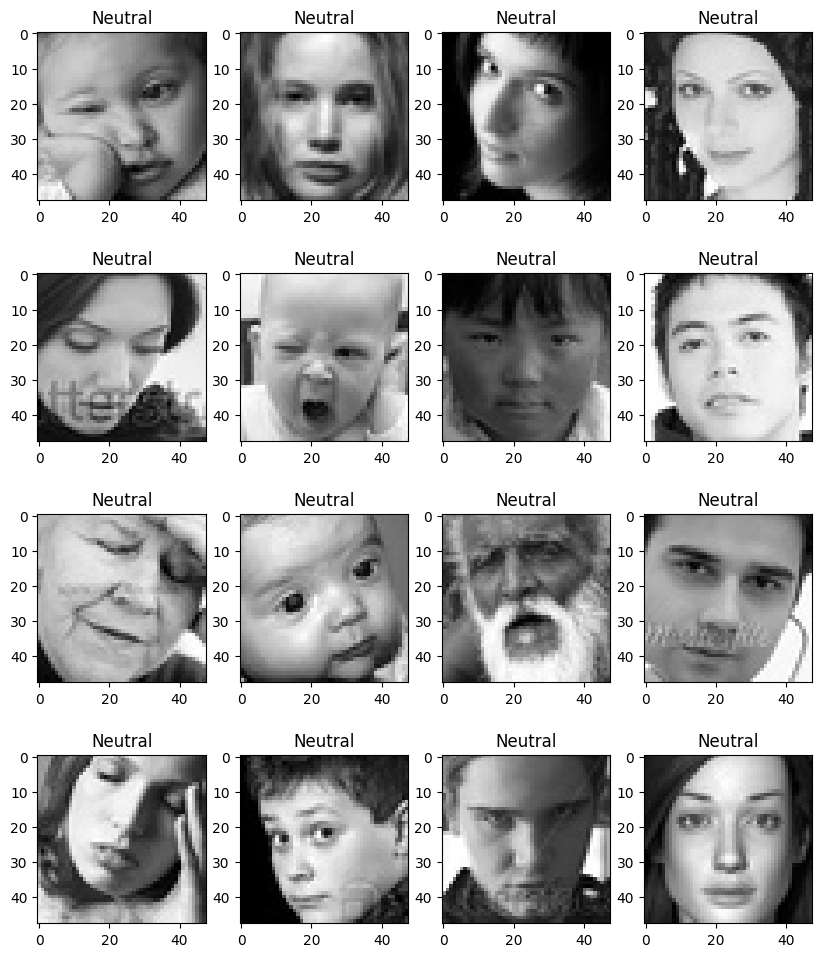

In [9]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/neutral", neutral[i])), cmap = 'gray')
    plt.title('Neutral')
plt.show()

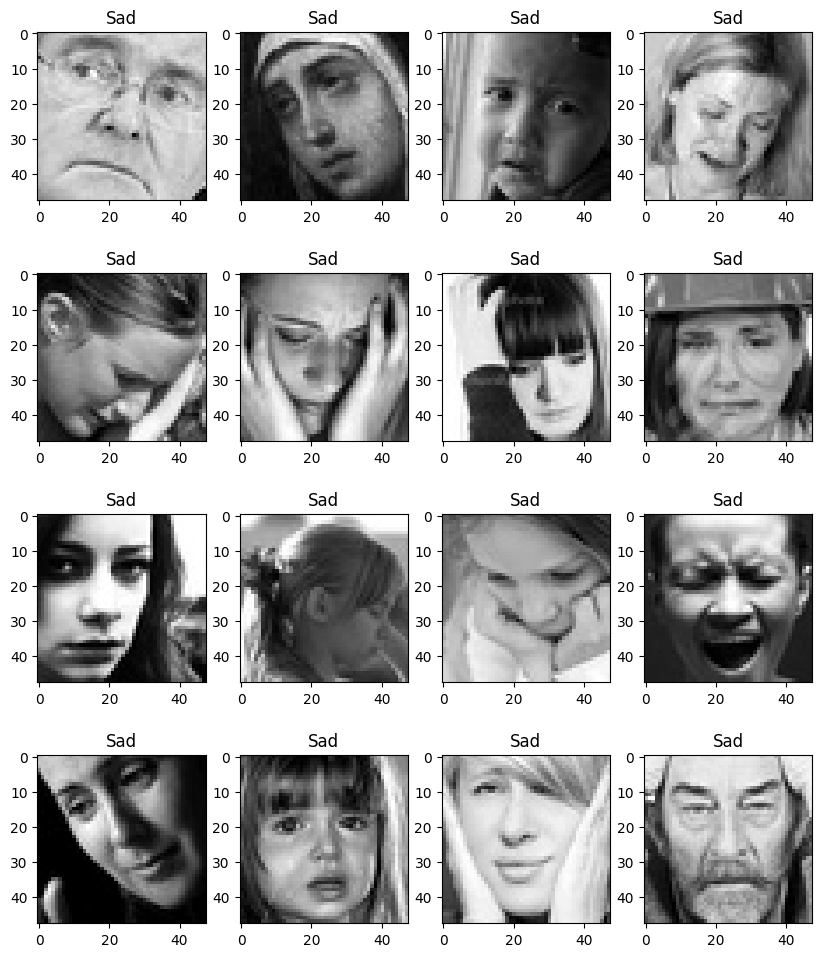

In [10]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/sad", sad[i])), cmap = 'gray')
    plt.title('Sad')
plt.show()

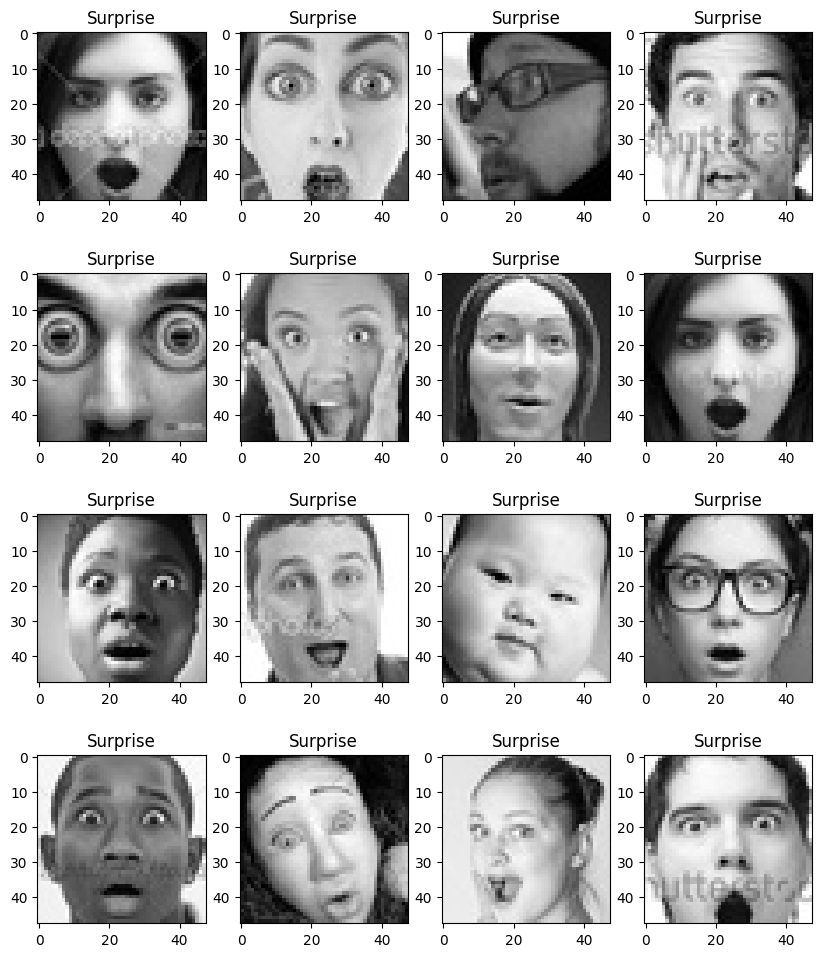

In [11]:
plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(train + "/surprise", surprise[i])), cmap = 'gray')
    plt.title('Surprise')
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size = 48
BATCH_SIZE = 16 
STEPS_PER_EPOCH = number_train

data_path = '/kaggle/input/fer2013'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 48, 48, 3)
test batch  (16, 48, 48, 3)
sample train label 
 [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [14]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [15]:
testing_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

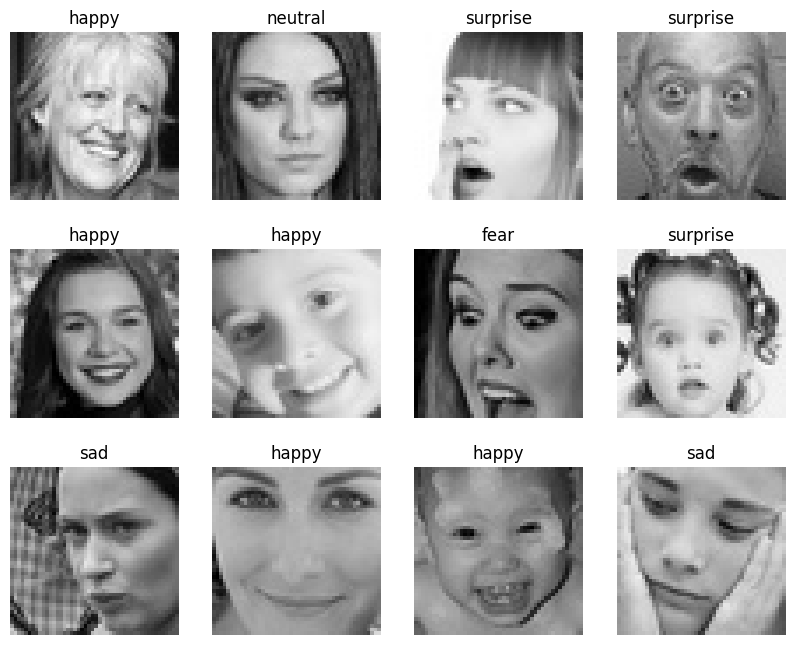

In [16]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [17]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import path
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from sklearn import metrics

from tensorflow.keras.regularizers import l2

In [18]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:
    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [19]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:
    
    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters
    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [20]:
from typing import List, Tuple

def ResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:

    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)
    
    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [21]:
image_size = (48, 48) 
channels = 3
num_classes = 7

In [22]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)

In [23]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 54, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1_1_conv      │ (None, 24, 24,    │      9,472 │ zero_padding2d[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1_1_nb        │ (None, 24, 24,    │        256 │ conv1_1_1_conv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24, 24,    │          0 │ conv1_1_1_nb[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 11, 11,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_1_conv      │ (None, 11, 11,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_1_bn        │ (None, 11, 11,    │        256 │ conv2_1_1_conv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_1_relu      │ (None, 11, 11,    │          0 │ conv2_1_1_bn[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_2_conv      │ (None, 11, 11,    │     36,928 │ conv2_1_1_relu[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_2_bn        │ (None, 11, 11,    │        256 │ conv2_1_2_conv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_2_relu      │ (None, 11, 11,    │          0 │ conv2_1_2_bn[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_3_conv      │ (None, 11, 11,    │     16,640 │ conv2_1_2_relu[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_short_conv  │ (None, 11, 11,    │     16,640 │ max_pooling2d[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_3_bn        │ (None, 11, 11,    │      1,024 │ conv2_1_3_conv[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_short_bn    │ (None, 11, 11,    │      1,024 │ conv2_1_short_co… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 11,    │          0 │ conv2_1_3_bn[0][

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
num_layers = len(model.layers)
num_layers 

177

In [25]:
model.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize 
    metrics=['accuracy'] # metrics to monitor
)

In [26]:
history = model.fit(
    training_set, 
    validation_data=testing_set,
    epochs = 40)

Epoch 1/40
   1/1795 ━━━━━━━━━━━━━━━━━━━━ 29:58:38 60s/step - accuracy: 0.0000e+00 - loss: 4.1846

I0000 00:00:1715530925.422937      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715530925.503577      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1794/1795 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2412 - loss: 2.1863

W0000 00:00:1715531075.680394      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 236s 98ms/step - accuracy: 0.2413 - loss: 2.1860 - val_accuracy: 0.3860 - val_loss: 1.7189
Epoch 2/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 69s 38ms/step - accuracy: 0.3464 - loss: 1.7838 - val_accuracy: 0.3462 - val_loss: 1.6746
Epoch 3/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 69s 38ms/step - accuracy: 0.3758 - loss: 1.6635 - val_accuracy: 0.3930 - val_loss: 1.7462
Epoch 4/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 69s 38ms/step - accuracy: 0.3527 - loss: 1.7061 - val_accuracy: 0.3430 - val_loss: 2.0681
Epoch 5/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.3957 - loss: 1.5466 - val_accuracy: 0.4603 - val_loss: 1.3964
Epoch 6/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.4356 - loss: 1.4532 - val_accuracy: 0.4572 - val_loss: 1.4224
Epoch 7/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.4592 - loss: 1.3957 - val_accuracy: 0.4700 - val_loss: 1.4439
Epoch 8/40
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.4802 - loss: 1.3

449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step


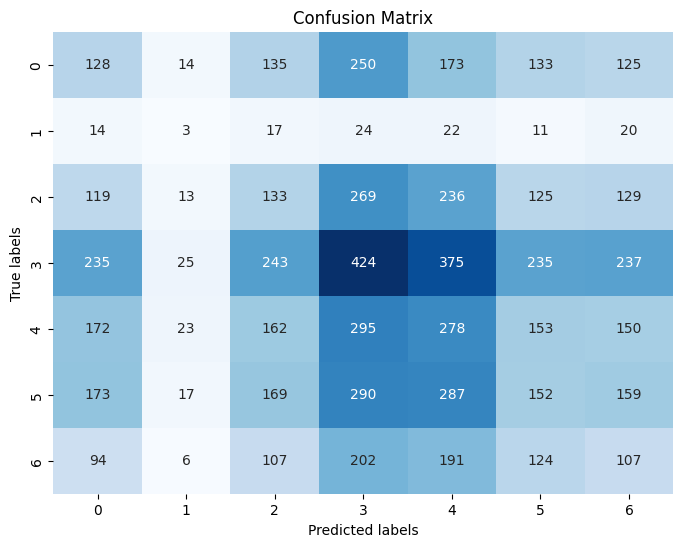

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the testing set
predictions = model.predict(testing_set)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the testing set
true_classes = testing_set.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from tensorflow.keras.utils import plot_model
image_path = 'model_architecture.png'

# Plot and save the model architecture image
plot_model(model, to_file=image_path, show_shapes=True)

print("Model architecture image saved to:", image_path)

Model architecture image saved to: model_architecture.png


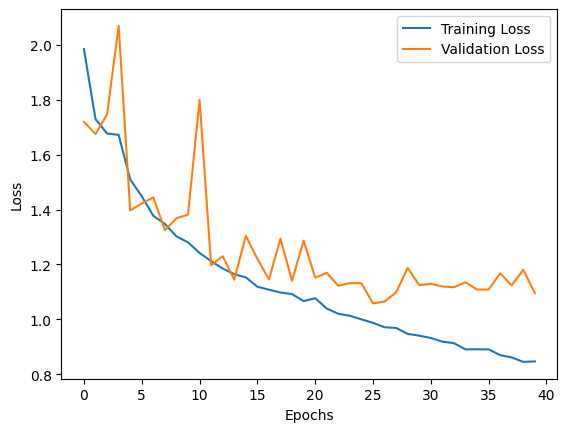

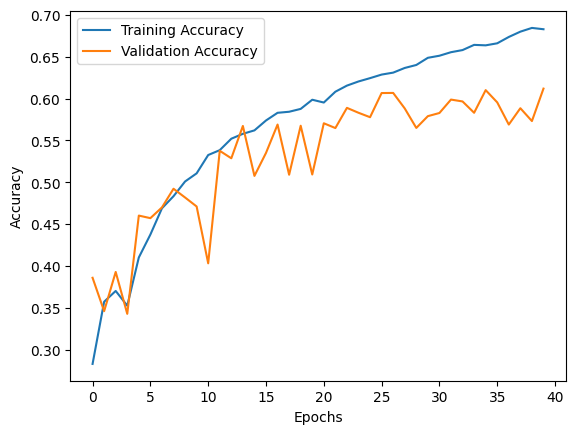

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()